#  Image processing: Transforming MNIST digits using optimal transport 



We first download the MNIST digit dataset

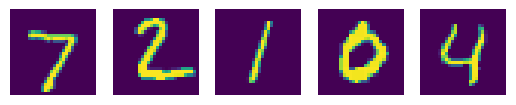

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(example_data[i][0])
    plt.axis("off")
plt.show()


We now take two images for our processing task.

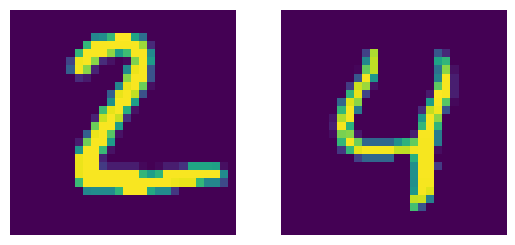

In [2]:
image1 = example_data[1][0]
image2 = example_data[4][0]
image1 = image1/image1.sum()
image2 = image2/image2.sum()

plt.subplot(1,2,1)
plt.imshow(image1)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image2)
plt.axis("off")
plt.show()


We now extract the "content" as cloud of points from the images and put them into a 2D plane.

/home/thultran/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-17 23:40:00.759839: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 23:40:00.821027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 23:40:00.821067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 23:40:00.822460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

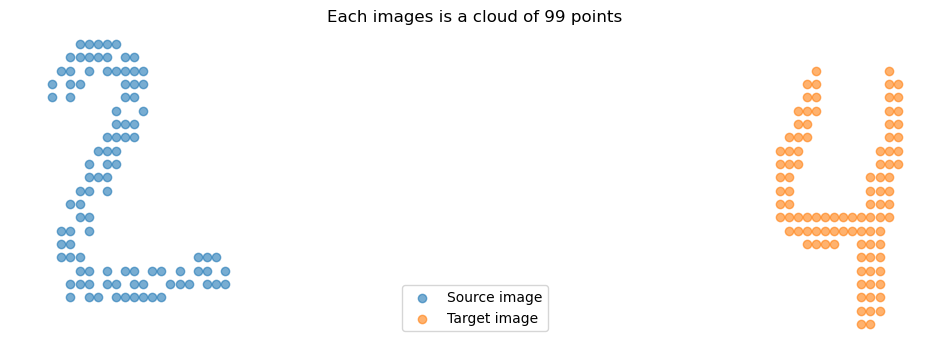

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import ot
import matplotlib.animation as animation
from IPython import display

N = 2
d = 2
I1 = image1 
I2 = image2
I1_max = image1.max()
I2_max = image2.max()


sz = I2.shape[0]
XX, YY = np.meshgrid(np.arange(sz), np.arange(sz))

alpha = 0.2

x1 = np.stack((XX[I1 >= alpha*I1_max], -YY[I1 >= alpha*I1_max]), 1) * 1.0
x2 = np.stack((XX[I2 >= alpha*I2_max]+80, -YY[I2 >= alpha*I2_max]), 1) * 1.0

n = int(min(x1.shape[0], x2.shape[0]))
x1_rand_positions = np.random.choice(range(x1.shape[0]), n,replace=False)
x1 = x1[x1_rand_positions, :]
x2_rand_positions = np.random.choice(range(x2.shape[0]), n, replace=False)
x2 = x2[x2_rand_positions, :]


plt.figure(1, (4*3, 4))
plt.scatter(x1[:, 0], x1[:, 1], alpha=0.6, label='Source image')
plt.scatter(x2[:, 0], x2[:, 1], alpha=0.6, label='Target image')
plt.title(f'Each images is a cloud of {n} points')
plt.legend()
plt.axis("off")
plt.show()

We now apply the Optimal Transport to find the "optimal" map transforming image1 to image2.

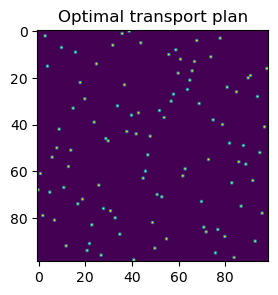

In [4]:
a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples x1, x2
# loss matrix
M = ot.dist(x1, x2)

# solve optimal transport problem
G0 = ot.emd(a, b, M)


plt.figure(2, (3, 3))
plt.imshow(G0)
plt.title("Optimal transport plan")
plt.show()

We now draw the optimal pairing between the point from source image (image1) to the target image (image2).

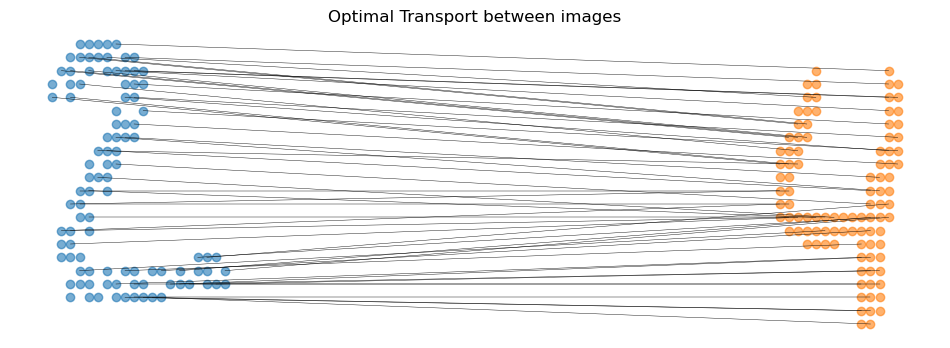

In [5]:
def get_pairs(G0):
    n = G0.shape[0]
    pairs = []
    for i in range(n):
        for j in range(n):
            if G0[i, j] !=0:
                pairs += [(i, j)]

    return pairs

def new_images_with_aranging_points(image_1, image_2):
    pairs = get_pairs(G0) 
    img1_indices = [p[0] for p in pairs]
    img2_indices = [p[1] for p in pairs]
    return image_1[img1_indices, :], image_2[img2_indices, :]

img1, img2 = new_images_with_aranging_points(x1, x2)

plt.figure(3, (12, 4))
plt.scatter(x1[:, 0], x1[:, 1], alpha=0.6)
plt.scatter(x2[:, 0], x2[:, 1], alpha=0.6)
for i in range(img1.shape[0]):
    if i%2==0:
        plt.plot([img1[i, 0], img2[i, 0]], [img1[i, 1], img2[i, 1]], c="k", lw=0.3)
plt.title('Optimal Transport between images')
plt.axis("off")
plt.show()

We now create an animation moving the points from image1 to image2 using the pairing obtained above.

In [7]:
nb_iter_max = 50
times = np.linspace(0., 1., nb_iter_max).reshape(-1, 1, 1)
x_all = (1-times)* img1 + times* img2
fig, ax = plt.subplots(figsize=(12, 4))
def _update_plot(i):
    plt.clf()
    plt.scatter(x1[:, 0], x1[:, 1], alpha=0.5, color="blue")
    plt.scatter(x2[:, 0], x2[:, 1], alpha=0.5, color="orange")
    if i<= nb_iter_max//2:
        color = "blue"
    else:
        color = "orange"
    plt.scatter(x_all[i, :, 0], x_all[i, :, 1], c=color, alpha=0.3)
    plt.title(f"Image interpolation at time ti={round(float(times[i]) , 2)} and iteration i={i}")
    plt.axis("off")
    # plt.axis(ax)
    return 1

# create animation
ani = animation.FuncAnimation(fig, _update_plot, frames=nb_iter_max, interval=500)

#save as a gif image
ani.save('MNIST.gif', writer='imagemagick', fps=5)

# display animation as video
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

/tmp/ipykernel_9311/3998645446.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Image interpolation at time ti={round(float(times[i]) , 2)} and iteration i={i}")
/tmp/ipykernel_9311/3998645446.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Image interpolation at time ti={round(float(times[i]) , 2)} and iteration i={i}")
